In [37]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('../output_files/positions_data.txt', sep=' ', names=['particle', 'time', 'x', 'y'])

In [38]:
def squared_displacement(group):
    initial_position = group.iloc[0][['x', 'y']]
    displacement = group[['x', 'y']] - initial_position
    squared_disp = displacement.pow(2).sum(axis=1)
    return pd.DataFrame({'time': group['time'], 'squared_displacement': squared_disp})

grouped_data = data.groupby('particle').apply(squared_displacement)
msd = grouped_data.groupby('time').mean().reset_index()

In [46]:
dimension = 2
slope, intercept, r_value, p_value, std_err = stats.linregress(msd['time'], msd['squared_displacement'])
diffusion_constant = slope / (2 * dimension)

print("D:", diffusion_constant)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)

D: 0.10196052997034216
Slope: 0.40784211988136865
Intercept: 29.87256073605596
R-squared: 0.9291068774661413


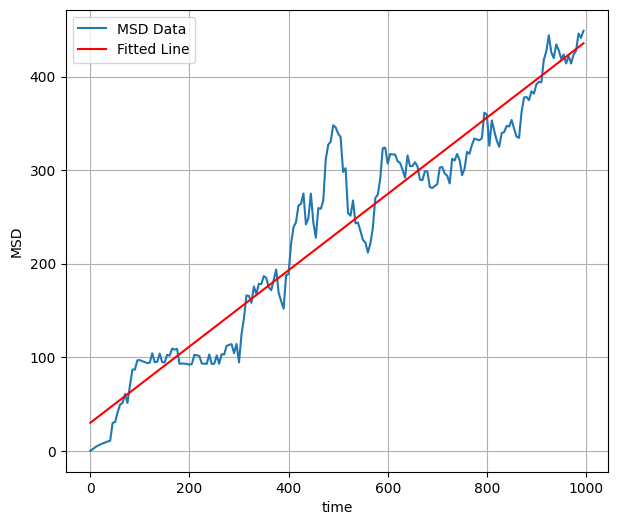

In [48]:
plt.figure(figsize=(7, 6))  

plt.plot(msd.time, msd.squared_displacement, label='MSD Data')
plt.plot(msd['time'], intercept + slope * msd['time'], 'r', label='Fitted Line')

plt.xlabel('time')
plt.ylabel('MSD')

plt.legend()
plt.grid()
plt.show()